# **<center>Imports</center>**

In [1]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers.merging import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from skimage.io import imsave
import cv2

#Utilities
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


# **<center>Data Collection</center>**

In [2]:
train_data_path = "photos/train/"
test_data_path = "photos/test/"

In [3]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(train_data_path, target_size=(256,256), batch_size=15, class_mode=None)

Found 1500 images belonging to 1 classes.


In [4]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(test_data_path, target_size=(256, 256), batch_size=15, class_mode=None)

Found 1500 images belonging to 1 classes.


In [8]:
def prepareInputData(path, h, w):
    X = []
    y = []
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            img_l = img_lab[:, :, 0]  # L channel
            img_ab = img_lab[:, :, 1:]  # ab channels
            img_ab = img_ab / 128.0  # Scale ab channels to range -1 to 1
            
            # Resize images if necessary
            img_l_rs = cv2.resize(img_l, (w, h))
            img_ab_rs = cv2.resize(img_ab, (w, h))
            
            X.append(img_l_rs)
            y.append(img_ab_rs)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [9]:
X_train,y_train = prepareInputData(train_data_path + "train_data/", 256, 256)
X_test, y_test = prepareInputData(test_data_path + "test_data/", 256, 256)

In [12]:
np.unique(X_train[0])

array([  0.      ,  32.2937  ,  53.240967,  60.321045,  87.73804 ,
        91.11328 ,  97.13745 , 100.      ], dtype=float32)

In [13]:
np.unique(y_train[6])

array([-0.84265137, -0.67333984, -0.37573242, -0.16833496, -0.11035156,
        0.        ,  0.61865234,  0.6497803 ,  0.7380371 ], dtype=float32)

# **<center>Making the Model</center>**

In [14]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [15]:
networkInput = Input(shape=(256, 256,1))
networkOutput = createModel(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='batch_normalization_1/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='batch_normalization_4/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [78]:
ALPHA = 0.5
BETA = 0.5

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [79]:
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [80]:
def my_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    C_pred = tf.sqrt(y_pred[0]**2 + y_pred[1]**2)
    C_true = tf.sqrt(y_true[0]**2 + y_true[1]**2)
#    h_pred = tf.atan2(y_pred[1], y_pred[0])
#    h_true = tf.atan2(y_true[1], y_true[0])
#    loss = (tf.sqrt((C_true - C_pred)**2 + 0.01*(h_true - h_pred)**2))/(100.64)
    loss = tf.sqrt((C_true - C_pred)**2)
#    loss = tf.sqrt((y_true[0]-y_pred[0])**2 + (y_true[1] - y_pred[1])**2)
    return loss

In [16]:
LEARNING_RATE = 0.001
model.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss="mse", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

history = model.fit_generator(GenerateInputs(X_train,y_train),epochs=12,verbose=1,steps_per_epoch=8,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=50)

Epoch 1/12
8/8 [==============================] - 37s 5s/step - loss: 0.1412 - acc: 0.4550 - val_loss: 0.9057 - val_acc: 0.9677
Epoch 2/12
8/8 [==============================] - 40s 5s/step - loss: 0.1001 - acc: 0.3029 - val_loss: 1.0023 - val_acc: 0.9862
Epoch 3/12
8/8 [==============================] - 29s 4s/step - loss: 0.0658 - acc: 0.1999 - val_loss: 1.0090 - val_acc: 0.9445
Epoch 4/12
8/8 [==============================] - 25s 3s/step - loss: 0.0516 - acc: 0.5014 - val_loss: 0.5502 - val_acc: 0.9475
Epoch 5/12
8/8 [==============================] - 26s 3s/step - loss: 0.0178 - acc: 0.4841 - val_loss: 0.9878 - val_acc: 0.9717
Epoch 6/12
8/8 [==============================] - 25s 3s/step - loss: 0.0130 - acc: 0.6944 - val_loss: 0.9967 - val_acc: 0.9545
Epoch 7/12
8/8 [==============================] - 26s 3s/step - loss: 0.0166 - acc: 0.4841 - val_loss: 0.9852 - val_acc: 0.9535
Epoch 8/12
8/8 [==============================] - 25s 3s/step - loss: 0.0315 - acc: 0.7601 - val_loss: 1

In [18]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [19]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

# **<center>Testing the Model</center>**

In [23]:
def ExtractTestInput(img):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_=img_.astype(np.float32)
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [24]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = model.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 269ms/step
Prediction made
reshaped


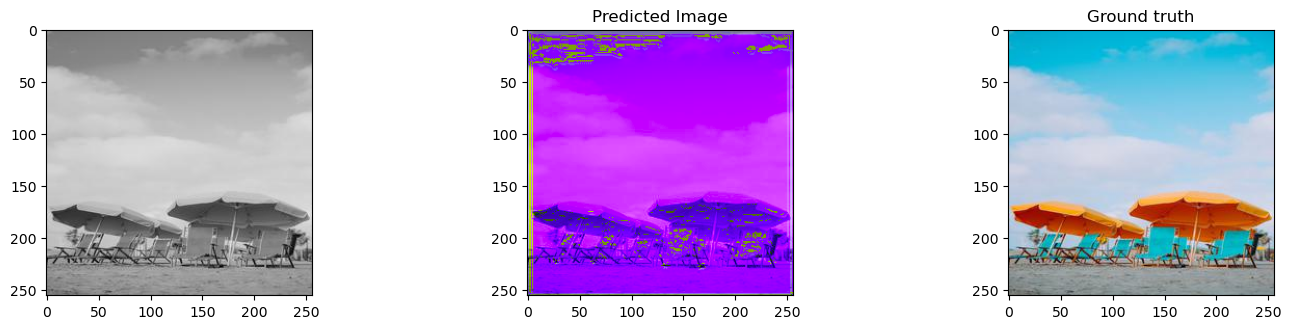

In [25]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)